Welcome to Day 3 of the Practicals !!

The goal of today is to use Dimentionality Reduction technics on whole-brain data.

**What is Dimentionality Reduction ?**  
The goal of Dimentionality Reduction (DR) is to transform data which has $D$ dimentions into a new space of dimention $d$ with $d<D$. We will refer to any such transformation as $D→d$.  
DR spans everything from simple averaging, up to very complex Machine Learning algorithms which are completly out of the scope of this tutorial. We are going to focus on a few intermidiary methods which are conceptually relatively complicated, but which are very easy to use in practice.  
You will see that the biggest problem with DR is not the programming itself (because most of the time you will use librairies which already exist) but **the biggest problem is how to interpret the results !** Hence this tutorial is not going to involve a lot of programming, but will instead focus on building your understanding of DR methods.

**Why do we use Dimentionality Reduction**  
First of all when you have thousands of neurons it can be very very hard to get an intuition of what is happening in the data. A good way of solving this problem is to reduce the dimensionality to something which can be plotted in 2D or 3D.   
Another important use case of DR is to find emerging properties in your data. A lot of interesting dynamics/properties do not happen at the scale of individual neurons, but happen instead at the scales of groups of neurons or perhaps the entire brain. Some DR methods allow you to identify those emerging properties.


During this tutorial, we will use the following markers :
- ➡️👤⌨️ : shows you what/were you need to code yourself.
- 💡 : shows hints to help you if you need it.
- ❗ : shows important notes.
- ⚠️ : shows warnings.

❗ We remind you that at any time, you can run `?thing` to get the documentation for `thing`. Typicaly, this is useful if `thing` is a function, and you need to know what are its parameters and/or what it does.

# 0.0. Settup Colab

In [ ]:
!mkdir /content/Helper_Functions/
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/accessing_data.py
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/plotting_functions.py
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/OrthoViewer.py
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/dimred_helper.py

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

In [ ]:
!gdown --folder 1k21VhLoonOnoxxXyswrmE45VIB4FF00n

In [ ]:
!pip install kneed

# 0.1. Imports

As usual lets start by importing a few librairies and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import h5py
import scipy
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy as hier
from scipy.interpolate import interp1d
from tqdm import tqdm
from sklearn.metrics import silhouette_score, silhouette_samples
from kneed import KneeLocator
import ipywidgets as widgets
from sklearn.decomposition import PCA, FastICA
from tqdm import tqdm
from sklearn.manifold import TSNE

In [2]:
import sys
sys.path.append("../")

In [3]:
from Helper_Functions.accessing_data import h5tree_view
from Helper_Functions.OrthoViewer import OrthoAxes
from Helper_Functions.plotting_functions import *
from Helper_Functions.dimred_helper import *

# 0.2. Get the data

We will use data coming from the same experiment as yesterday. However, yesterday the visual stimulus was always in the same direction but at different speeds, whereas today the **speed of the stimulus is constant but along different directions**.

![setup](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/experimental_setup_danionella.png)

Let's load the data.  
You will find it in the hdf5 file `banyuls_data/fish1_different_directions.hdf5`. Load this file and show the data tree.

Like yesterday, you will see that this file is split into 3 sections. We will need to load the following arrays :
- `brain`
  - neurons coordinates (in xyz space)
  - ΔF/F for each neuron
  - times at which the brain was imaged
- `stimulus`
  - direction of the visual stimulus
  - times at which the stimulus was updated
- `tail`
  - mean deflection of the tail
  - forward thrust
  - side thrust
  - times at which the tail was imaged


In [4]:
filepath = "../content/banyuls_data/fish1_different_directions.hdf5"
file = h5py.File(filepath, "r")
h5tree_view(file)

. ../content/banyuls_data/fish1_different_directions.hdf5
├── 📁brain
│   ├── 🔢coordinates ⚙️(3, 30971)float64
│   ├── 🔢dff ⚙️(30971, 961)float64
│   ├── 🔢times ⚙️(961,)float64
├── 📁stimulus
│   ├── 🔢direction ⚙️(28753,)float64
│   ├── 🔢speed ⚙️(28753,)float64
│   ├── 🔢times ⚙️(28753,)float64
├── 📁tail
│   ├── 🔢coordinates ⚙️(72214, 11, 2)float64
│   ├── 🔢deflection ⚙️(72214,)float64
│   ├── 🔢forward_thrust ⚙️(72214,)float64
│   ├── 🔢side_thrust ⚙️(72214,)float64
│   ├── 🔢times ⚙️(72214,)float64


In [5]:
coords = file["/brain/coordinates"][:]
dffs = file["/brain/dff"][:]
brain_time = file["/brain/times"][:]

direction = file["/stimulus/direction"][:]
stim_time = file["/stimulus/times"][:]

tail = file["/tail/deflection"][:]
forward_thrust = file["/tail/forward_thrust"][:]
side_thrust = file["/tail/side_thrust"][:]
tail_time = file["/tail/times"][:]

As we will want to compare brain activity, stimulus, and behavior later during this tutorial, the behavior and stimulus need to be downsampled at the brain imaging frequency.  
➡️👤⌨️ **Interpolate `direction`, `tail`,`forward_thrust`, and `side_thrust` so they are temporaly coherent with `dffs`.** ➡️👤⌨️

💡 You can use the function `np.interp` (or like yesterday `interp1d`).

In [6]:
# ➡️👤⌨️
direction = np.interp(brain_time, stim_time, direction)
tail = np.interp(brain_time, tail_time, tail)
forward_thrust = np.interp(brain_time, tail_time, forward_thrust)
side_thrust = np.interp(brain_time, tail_time, side_thrust)

➡️👤⌨️ **Create a new signal `flow_on` which is equal to 1 when the stimulus is on (ie. `direction`$\neq$NaN), and 0 otherwise.** ➡️👤⌨️

💡 you can use the function `np.isfinite` to find when `direction`$\neq$NaN.

In [7]:
flow_on = np.where(np.isfinite(direction), 1, 0)

# 0.3. Observe the Data

Let's start as usual by looking at the data.

Text(0, 0.5, 'Flow ON/OFF')

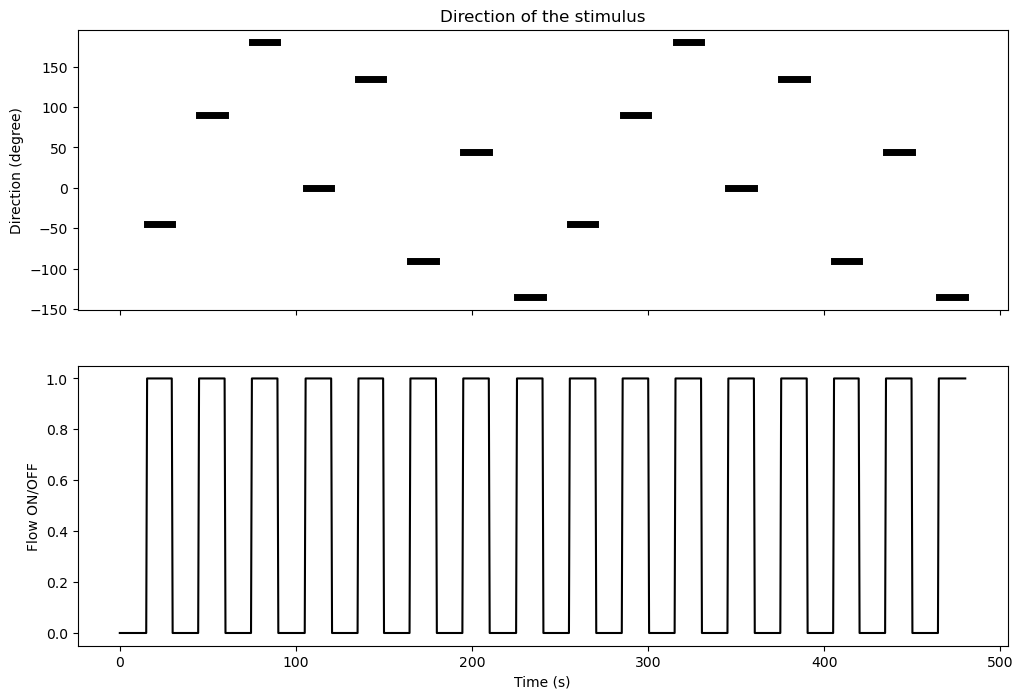

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(12,8), sharex=True)
ax=axs[0]
ax.plot(brain_time, direction, color="k", linewidth=5)
ax.set_ylabel("Direction (degree)")
ax.set_title("Direction of the stimulus")
ax = axs[1]
ax.plot(brain_time, flow_on, color="k")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Flow ON/OFF")

Text(0.5, 1.0, 'ΔF/F of all neurons')

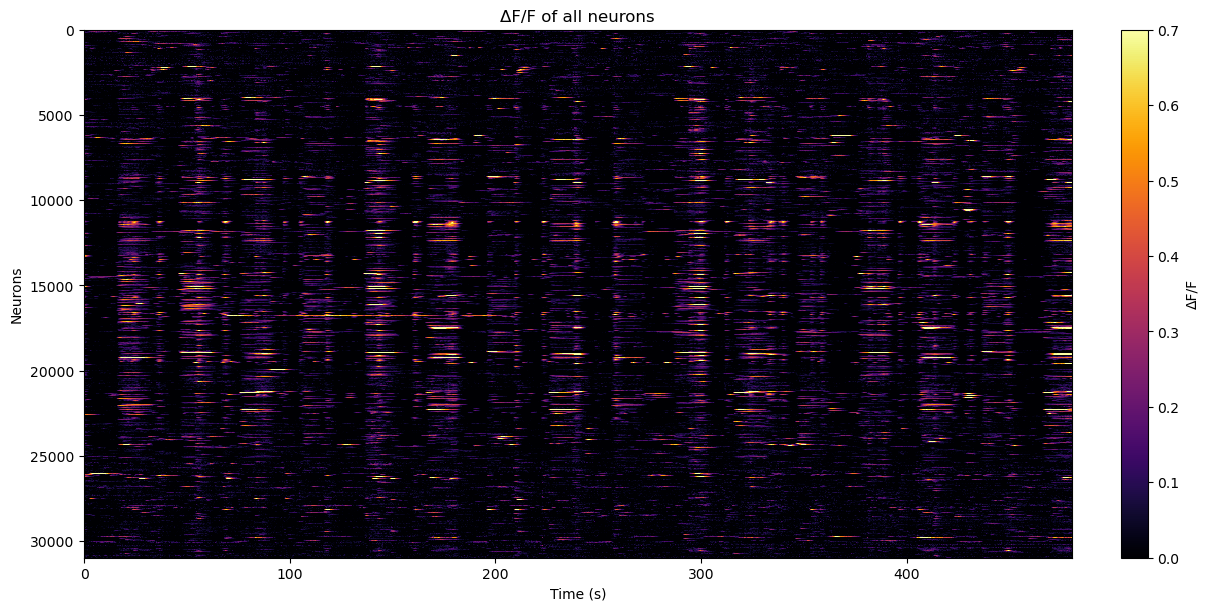

In [9]:
fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
cr = ComplexRaster(
    ax, dffs,
    times=brain_time,
    X_params={'cmap': 'inferno', 'vmin': 0, 'vmax': 0.7},
)
fig.colorbar(cr._im_dff, ax=ax,label="ΔF/F")
ax.set_title("ΔF/F of all neurons")

Text(0.5, 0.98, 'Behavioral signals')

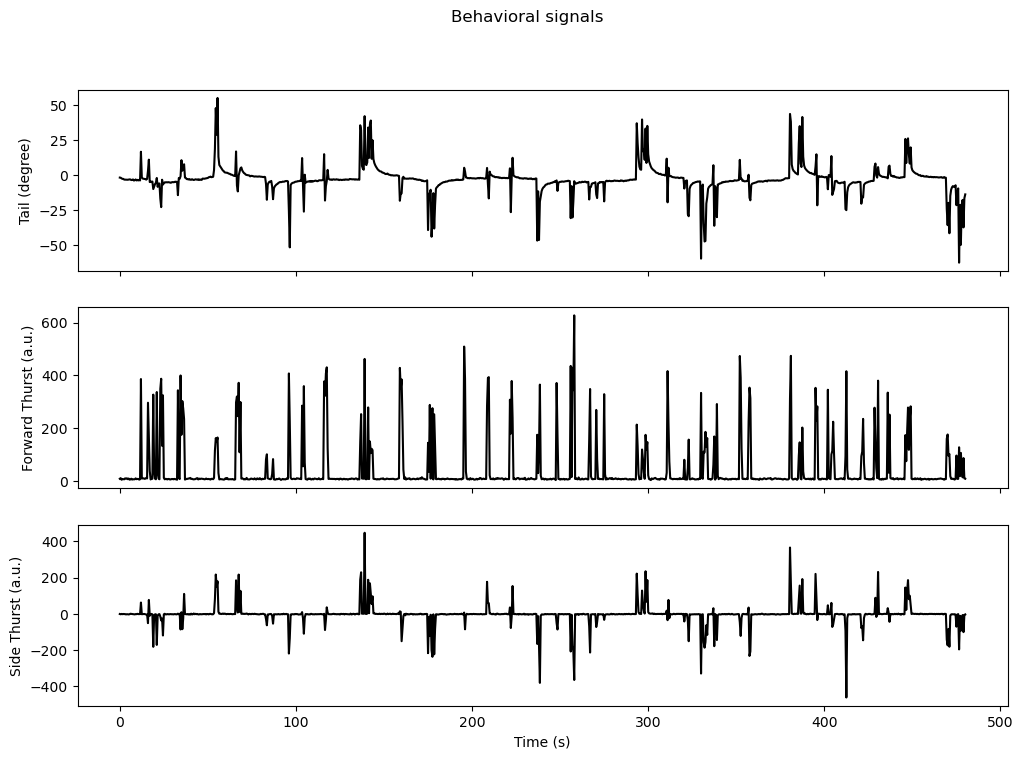

In [10]:
fig, axs = plt.subplots(nrows=3,figsize=(12,8), sharex=True)
axs[0].plot(brain_time, tail, color="k")
axs[1].plot(brain_time, forward_thrust, color="k")
axs[2].plot(brain_time, side_thrust, color="k")
axs[2].set_xlabel("Time (s)")
axs[0].set_ylabel("Tail (degree)")
axs[1].set_ylabel("Forward Thurst (a.u.)")
axs[2].set_ylabel("Side Thurst (a.u.)")
fig.suptitle("Behavioral signals")

For now, this looks very similar to what we did yesterday. However, what we are doing today is conceptualy very different.

**Yesterday, the questions were :**

    - Can we identify neurons which follow behavioral/stimuli signals ?
    - Where are those neurons located in the brain ?
→ we forced the algorithms to learn from the external signals

**Today, the questions are :**

    - Can we cluster neurons into groups ?
    - Can we interpret the activity of those clusters using behavior/stimuli ?
    - Can we find modes in the activity of the brain ?
    - Can we interpret those modes using behavior/stimuli ?
→ we try to find structure in the neuron-activity data, then compare these structures with external signal

# 1. Clusterize with KMeans

In this section we will use k-means clustering to find groups of neurons which have similar activity.  

**Small reminder abour KMeans**  
![k-means](https://upload.wikimedia.org/wikipedia/commons/7/7b/Kmeans_animation_withoutWatermark.gif "source : wikimedia | author : Incheol")

k-means is a clustering algorithm, which means that it divides the data into groups by dividing the space into regions (aka. partitioning).  
Imagine you have $D$ objects $(\mathbf{x}_1, ..., \mathbf{x}_D)$ which you want to devide into $k$ groups (aka. $k$ clusters).  
$\Delta_{ij} = ||\mathbf{x}_i - \mathbf{x}_j||^2$ is the distance between objects $i$ and $j$.  

k-means will assign each $\mathbf{x}_i$ to 1 (and only 1) cluster $K_{\alpha}$ ($i\in K_{\alpha}$), in a way that minimizes the distance between objets which belong in the same cluster. This means that :
$$\Delta_{ij} < \Delta_{im} \text{  , if  } i,j\in K_{\alpha} \text{  and  } m\in K_{\beta} \text{  ,  with  } \alpha\neq\beta$$

The center of each cluster $\mu_k$ is called its centroid (the triangles in the GIF above). When using k-means as a dimentionality reduction tool, we usualy use the $k$ centroid as a reduced version of the original data  : $D→k$.

In [11]:
# general parameters that we will re-use
kmeans_params = {
    "init":"k-means++",
    "n_init":10, 
    "random_state":0,
    "max_iter":300,
}

## 1.1 (Optional) Finding optimal number of clusters

Anytime we do a Dimentionality Reduction $D→d$, we must ask "how do I choose $d$ ?" .  
This is a very complicated subject which would require an entire course. Here we will use a very basic method called the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). However, the elbow method is usualy not enough. If you want to go in more depth on this subject, you can start with the [wikipedia article](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) on the subject.

The idea behind the elbow method is to perform multiple clusterings with different number of clusters $k$, and compute for each the Sum of Squared Errors (SSE), which is the distance between each object and the closest centroid $SSE = \sum_{k,i\in K_k}||\mathbf{x}_i - \mu_k||^2$. 

➡️👤⌨️ **Compute the SSE for multiple k-means clustering with 2 to 10 clusters** ➡️👤⌨️

💡 you can use `kmeans = KMeans(n_clusters=k, **kmeans_params)` to initialize a clustering and `kmeans.fit(dffs)` to train it.  
💡 you can get the SSE from a trained `kmeans` by using `kmeans.inertia_`.  
⚠️ running multiple k-means clustering can be quite slow. This could take more than 5 minutes to run.


In [12]:
# ➡️👤⌨️
SSEs = []
Ks = []

for k in tqdm(range(2,10)):
    Ks.append(k)
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(dffs)
    SSEs.append(kmeans.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:36<00:00, 12.05s/it]


Text(0.5, 0, '# Clusters')

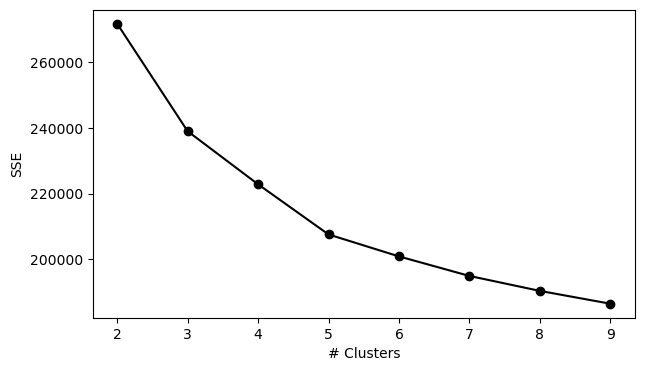

In [13]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(Ks, SSEs, "-o", color="k")
ax.set_ylabel("SSE")
ax.set_xlabel("# Clusters")

Now let's find the *elbow* in the curve, that is, the point at which the curve has maximum curvature. We will do this using the `KneeLocator` function from the `kneed` librairy. According to the Elbow method, this is the optimal number of cluster we should use.

In [14]:
kl = KneeLocator(Ks, SSEs, curve="convex", direction="decreasing")

Text(2.5, 207537.12405544324, '2.1E+05')

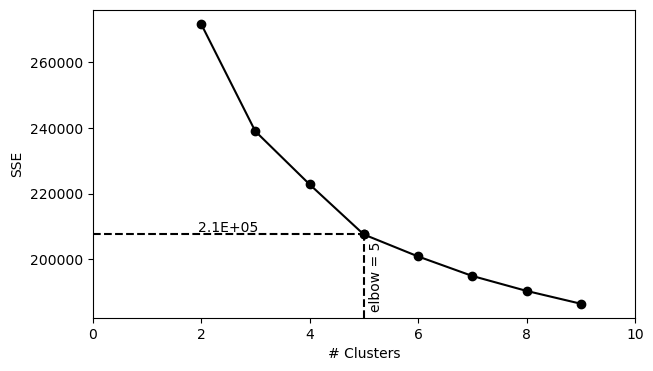

In [15]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(Ks, SSEs, "-o", color="k")
ax.set_ylabel("SSE")
ax.set_xlabel("# Clusters")
r = np.ptp(SSEs)*0.05
mmin, mmax = np.min(SSEs)-r,np.max(SSEs)+r
height = SSEs[kl.elbow-2]
ax.set_ylim(mmin, mmax)
ax.set_xlim(0,np.max(Ks)+1)

ax.scatter(kl.elbow, height, color="k")
ax.vlines(kl.elbow, mmin, height, color="k", linestyle="--")
ax.hlines(height, 0, kl.elbow, color="k", linestyle="--")
ax.text(kl.elbow+0.1, (height+mmin)/2, f"elbow = {kl.elbow}", ha="left", va="center", rotation="vertical")
ax.text(kl.elbow/2, height+0.01, f"{height:0.1E}", ha="center", va="bottom")


⚠️ Keep in mind that the elbow method is not a universal recipe and should not be followed blindly. In practice it should be combined with other methods, and your understanding of the system should also come into play.

## 1.2 Clustering brain activity

For this section, let's use only 5 clusters (it will make the analysis faster and easier).

In [16]:
kmeans = KMeans(n_clusters=5, **kmeans_params)
kmeans.fit(dffs)

KMeans(n_clusters=5, n_init=10, random_state=0)

➡️👤⌨️ **Using `kmeans.labels_` you can get the cluster number for each neuron. Check that everything is running correctly and that you have the right number on labels.** ➡️👤⌨️

In [17]:
# ➡️👤⌨️
kmeans.labels_.shape

(30971,)

Now we will plot our 5 clusters in our 3D brain to see what it looks like

(<matplotlib.collections.PathCollection at 0x7fa0484cd3f0>,
 <matplotlib.collections.PathCollection at 0x7fa0484fdea0>)

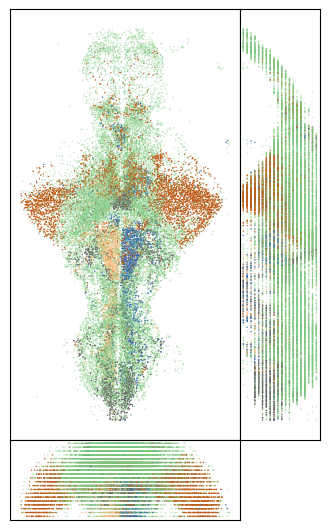

In [18]:
fig = plt.figure(figsize=(4,7))
ortho = OrthoAxes(fig, coords, interactive=False)
ortho.scatter(coords, c=kmeans.labels_, s=1, cmap="Accent", alpha=np.where(kmeans.labels_==0,0.5,1))

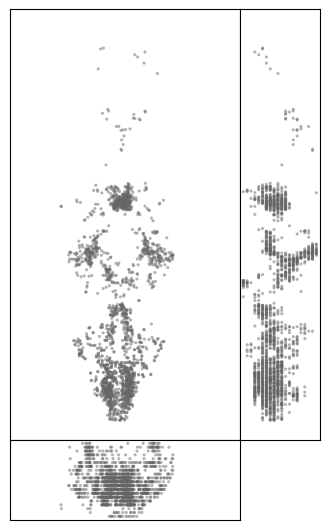

In [20]:
def plot_single_k(k=0):
    inds = np.where(kmeans.labels_==k)[0]
    fig = plt.figure(figsize=(4,7))
    ortho = OrthoAxes(fig, coords, interactive=False)
    ortho.scatter(coords[:,inds], c=kmeans.labels_[inds], s=5, cmap="Accent", alpha=0.5, vmin=kmeans.labels_.min(), vmax=kmeans.labels_.max())
    plt.show()
widgets.interact(plot_single_k, k=(0,kmeans.n_clusters-1,1))

From what you have learned yesterday, can you already guess what those 5 clusters correspond to ?

➡️👤⌨️ Now that we know which neurons bellong to which cluster, **create a function which gets the ΔF/F all the neurons in a cluster.** ➡️👤⌨️

In [21]:
def extract_cluster_dffs(X, labels, k):
    """Get dff of neurons in one cluster from cluster labels.

    Parameters :
    ------------
    :X: 2D array
        ΔF/F of neurons ( neuron x time ).
    :labels: 1D array
        cluster label for each neuron.
    :k: integer
        label for the cluster we want to extract.

    Results :
    ---------
    :subX: 2D array
        ΔF/F of neurons in cluster :k: ( neuron x time ).
    """
    assert X.ndim==2
    n,_ = X.shape
    assert labels.ndim==1
    assert len(labels)==n
    assert isinstance(k, int)

    # ➡️👤⌨️
    inds = np.where(labels == k)[0]
    subX = X[inds]
    # ➡️👤⌨️

    assert subX.ndim==2
    assert subX.shape[1]==X.shape[1]
    return subX

And now let's plot the raster plots of each cluster

Text(0.5, 0, 'Time (s)')

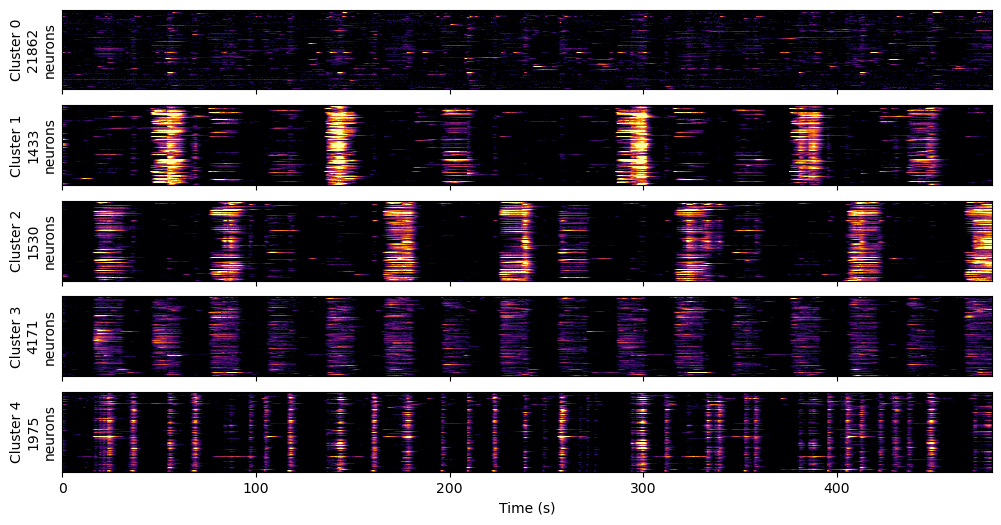

In [22]:
fig, axs = plt.subplots(nrows=kmeans.n_clusters, figsize=(12,6), sharex=True)
for k in range(kmeans.n_clusters):
    subdff = extract_cluster_dffs(dffs, kmeans.labels_, k)
    cr = ComplexRaster(
        axs[k], 
        subdff,
        times=brain_time,
        X_params={'cmap': 'inferno', 'vmin': 0, 'vmax': 0.7},
    )
    axs[k].set_xlabel("")
    axs[k].set_ylabel(f"Cluster {k}\n{len(subdff)}\nneurons")
    axs[k].set_yticks([])
axs[k].set_xlabel("Time (s)")

As you can see, the neurons in each cluster have very stereotypic activity. What do you think each cluster corresponds to ?

➡️👤⌨️ Let's now **get the centroid of our 5 clusters and plot them.** ➡️👤⌨️  
What do they represent ? Can you interpret them ? 

💡 you can use `kmeans.cluster_centers_`.

In [23]:
# ➡️👤⌨️
centroids = kmeans.cluster_centers_
centroids.shape

(5, 961)

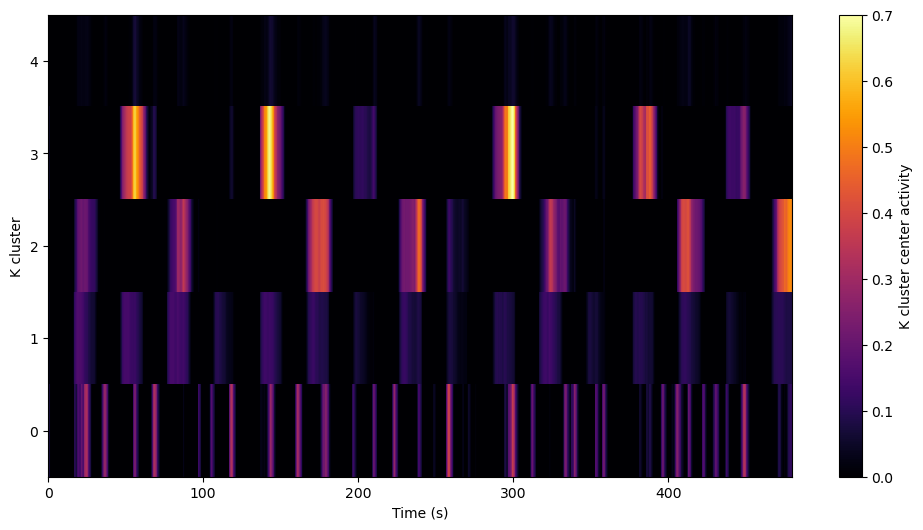

In [24]:
# ➡️👤⌨️
fig, ax = plt.subplots(figsize=(12,6))
h = ax.imshow(
    kmeans.cluster_centers_, 
    aspect="auto", interpolation="none", 
    cmap="inferno", vmin=0, vmax=0.7, 
    extent=(brain_time[0], brain_time[-1], 0-0.5, kmeans.n_clusters-0.5)
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("K cluster")
fig.colorbar(h, ax=ax, label="K cluster center activity")

## 1.3 Interpreting Clusters

As we said before, the main difficulty with dimentionality reduction, is the interpretation of the results.   
With k-means, the question is how to interpret the different clusters ? Are the groups of neurons we find physiologicaly relevant ? Functionaly relevant ? ...

In the interactive plot bellow, **try to interpret the centroids of each cluster using the behavioral and stimuli signals we computed earlier.**  

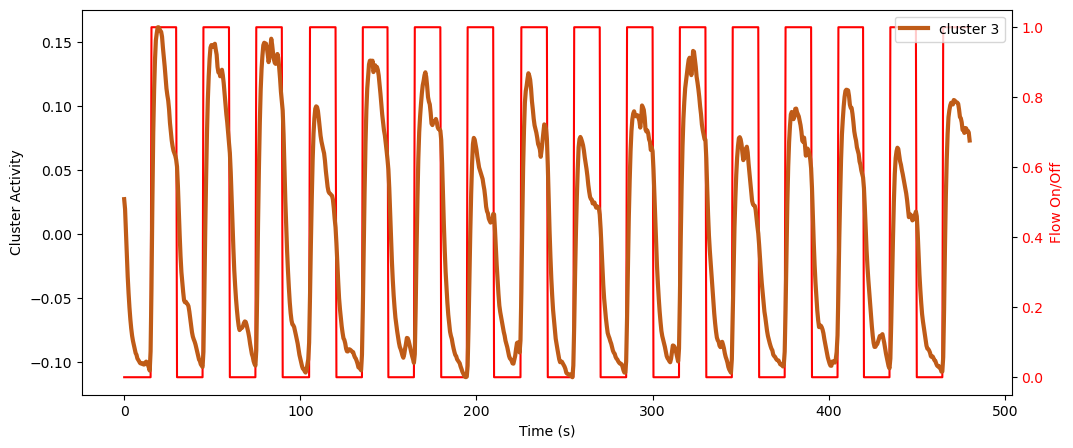

In [26]:
def plot_find_cluster_meaning(k=0, sig="flowon"):
    fig, ax = plt.subplots(figsize=(12,5))
    ax2 = ax.twinx()
    ax2.tick_params(axis='y', labelcolor="red")
    if sig == "tail":
        ax2.plot(brain_time, tail, color="red", label="")
        ax2.set_ylabel("tail (degree)", color="red")
    elif sig == "left":
        ax2.plot(brain_time, np.clip(side_thrust,0,1.e9), color="red", label="")
        ax2.set_ylabel("Left Thrust (a.u.)", color="red")
    elif sig == "right":
        ax2.plot(brain_time, np.clip(side_thrust,-1.e9,0), color="red", label="")
        ax2.set_ylabel("Right Thrust (a.u.)", color="red")
        ax2.invert_yaxis()
    elif sig == "forward":
        ax2.plot(brain_time, forward_thrust, color="red", label="")
        ax2.set_ylabel("Forward Thrust (a.u.)", color="red")
    elif sig == "direction":
        ax2.plot(brain_time, direction, color="red", label="tail (a.u.)", linewidth=5)
        ax2.set_ylabel("Direction (degree)", color="red")
    elif sig == "flowon":
        ax2.plot(brain_time, flow_on, color="red", label="flow on (a.u.)")
        ax2.set_ylabel("Flow On/Off", color="red")
    ax.plot(
        brain_time, kmeans.cluster_centers_[k], 
        color=plt.cm.Accent(np.linspace(0,1,5))[k], 
        linewidth=3, label=f"cluster {k}",
    )
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Cluster Activity")
    ax.legend()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.set_frame_on(False)
    plt.show()
widgets.interact(plot_find_cluster_meaning, k=(0,kmeans.n_clusters-1, 1), sig=["direction", "flowon", "tail", "forward", "left", "right"])

Did you find a clear interpretation for all clusters ? Can you use the spatial distribution of neurons we plotted earlier to refine your interpretations ?

## 1.4 Investigating single cluster in detail

In this section we will analyse a single k-means cluster in detail.  
➡️👤⌨️ **Start by extracting the neuron activity of cluster 1 as `small_dffs` and it's centroid `small_mu`.** ➡️👤⌨️

💡 you can use the function `extract_cluster_dffs` you coded earlier.

In [27]:
# ➡️👤⌨️
k = 1
small_dffs = extract_cluster_dffs(dffs, kmeans.labels_, k)
small_mu = centroids[k]

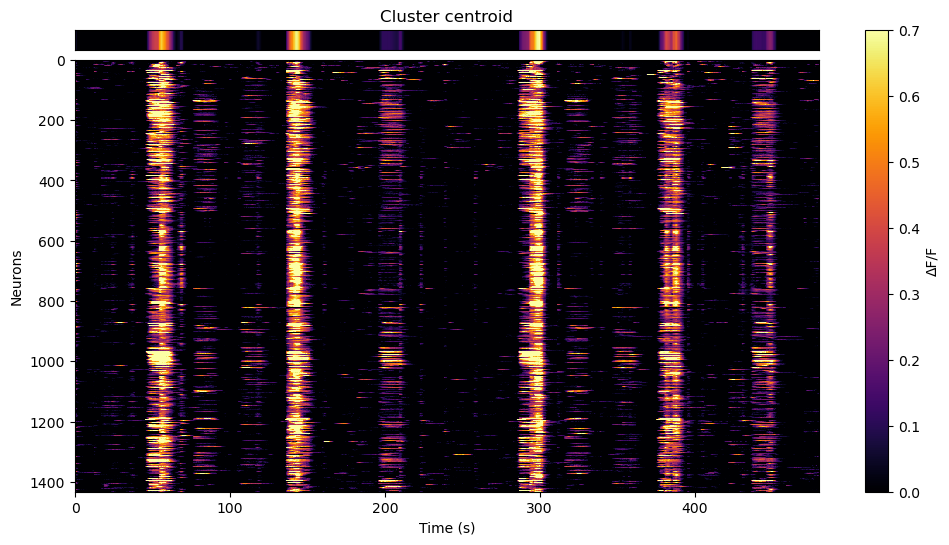

In [28]:
fig, ax = plt.subplots(figsize=(12,6))
cr = ComplexRaster(
    ax, small_dffs,
    signal=small_mu,
    times=brain_time,
    X_params={'cmap': 'inferno', 'vmin': 0, 'vmax': 0.7},
    signal_params={'cmap': 'inferno', 'vmin': 0, 'vmax': 0.7},
)
cr._ax_sig.set_title("Cluster centroid")
fig.colorbar(cr._im_dff, ax=ax,label="ΔF/F")

⚠️ For what we will be doing in this section, the RAM (working memory) is too small on Google Colab to work with more than 10000 neurons. The following line is a check to verify that the selected cluster does not contain more than 10k neurons.

In [29]:
if len(small_dffs) > 10000:
    raise TypeError("This cluster contains more than 10k neurons. Google Colab will not be able to deal with that.")

As expected, all the neurons in the cluster have an activity that looks like the centroid. BUT there is some variability which might be interesting.   
➡️👤⌨️ Let's make this very obvious by **creating a new array `clust_var`, which represents the *difference* between the activity of neurons and the cluster centroid.** ➡️👤⌨️

In [30]:
# ➡️👤⌨️
clust_var = small_dffs-small_mu

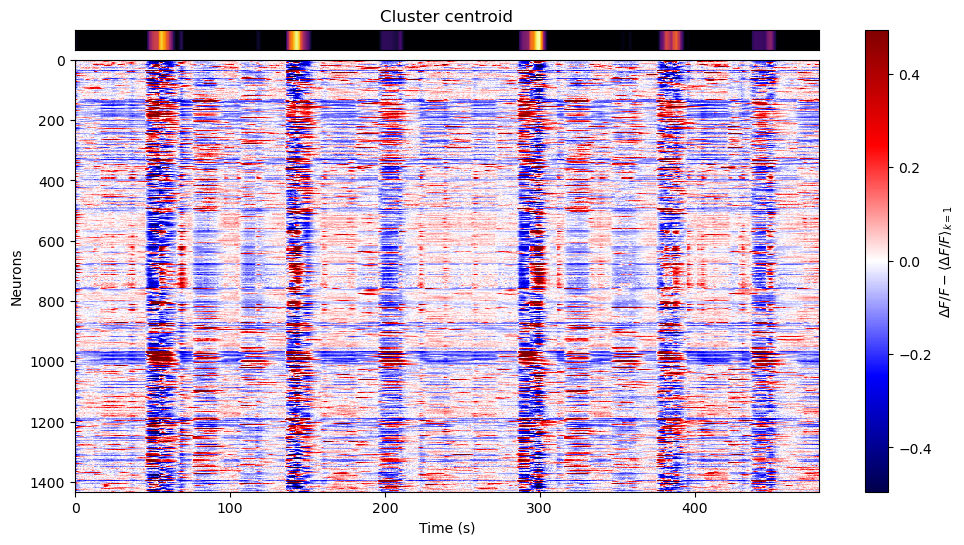

In [31]:
fig, ax = plt.subplots(figsize=(12,6))
l = np.abs(np.quantile(clust_var, [0.01, 0.99])).max()
cr = ComplexRaster(
    ax, clust_var,
    signal=small_mu,
    times=brain_time,
    X_params={'cmap': 'seismic', 'vmin': -l, 'vmax': +l},
    signal_params={'cmap': 'inferno', 'vmin': 0, 'vmax': 0.7},
)
cr._ax_sig.set_title("Cluster centroid")
fig.colorbar(cr._im_dff, ax=ax,label=r"$\Delta F/F - \langle \Delta F/F \rangle_{k="+str(k)+"}$")

➡️👤⌨️ **Now compute the correlation matrix `C` between each neurons, using `clust_var`.** ➡️👤⌨️  
What do you expect to see ?

In [32]:
Corr = np.corrcoef(clust_var)
Corr.shape

(1433, 1433)

Text(0, 0.5, 'Neuron j')

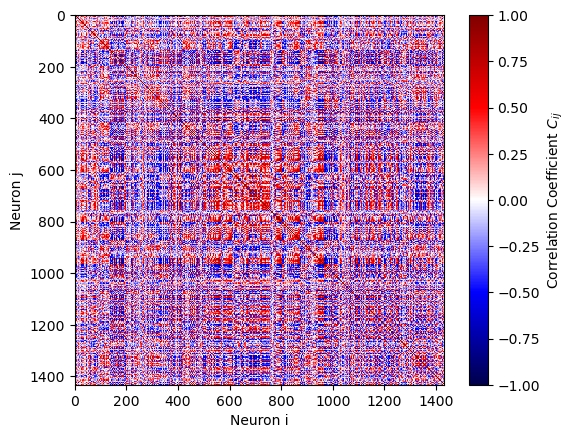

In [33]:
fig, ax = plt.subplots()
h = ax.imshow(Corr, cmap="seismic", vmin=-1, vmax=+1, interpolation="none")
fig.colorbar(h, ax=ax, label="Correlation Coefficient $C_{ij}$")
ax.set_xlabel("Neuron i")
ax.set_ylabel("Neuron j")

The raster plot and the correlation matrix of `clust_var` are very disordered, and therefore very hard to read. Idealy we would like neurons which have similar activities in `clust_var` to be next to each other. But how do we do that ?

### 1.4.1 Hierarchical Clustering

To do that we will use another clustering method called **Hierarchical Clustering (HC)**. This method is very powerful, but unfortunately it requires a lot of cumputer power.  
The idea is to start from a matrix of distances $\Delta_{ij} = \text{distance}(\mathbf{x}_i, \mathbf{x}_j)$ between different objects $\mathbf{x}_1,...,\mathbf{x}_D$, and then find a hierarchy of clusters based on $\Delta_{i,j}$. We will not talk about the algorithm behind this as it can be quite complicated, but if you are interested you can start by reading the [wiki page](https://en.wikipedia.org/wiki/Hierarchical_clustering) on the subject.  
Contrary to k-means where you need to specify the number of clusters you want from the start, HC builds the entire hierarchy, from 0 to $D$ clusters. And you can specify *a posteriori* the number of clusters $d$ you want.  
There are also algorithms, like the **optimal leaf** which can reorder the hierarchy structure so that clusters which are next to each other look like each other.

![HierClust](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/HierClust.png)

Let's start by computing the distance matrix $\Delta_{ij}$. We can do that from the correlation matrix $C_{ij}$ by setting $\Delta_{ij} = 1-C_{ij}$. Do you understand why ?  

However, the librairy `scipy.cluster.hierarchy` we are going to use doesn't take a full distance matrix as input. Instead it takes what is called a *condensed distance matrix*, that is the upper triangle of the matrix (without the diagonal).

➡️👤⌨️ **Compute the condensed distance matrix `condensed_dist` from `Corr`.** ➡️👤⌨️

💡 you can use the function `np.triu_indices_from(X, k=+1)` to get the idices for the upper triangle elements of the matrix `X`.

In [34]:
# ➡️👤⌨️
condensed_dist = 1-Corr[np.triu_indices_from(Corr, k=+1)]

Now we will performe the Hierarchical Clustering. We first need to compute a *linkage matrix*.

In [35]:
Z = hier.linkage(condensed_dist, metric="correlation", method="ward")

Now we can apply the optimal leaf algoritm to optain the optimal ordering of the clusters. This is an optional step, but it makes all the plots much more pretty.

⚠️ this step requires a lot of computer power. On Colab we will not be able to apply this algorithm on more than 2000 neurons.

In [36]:
%%time
if len(Z) < 2000:
    opt_leaf = hier.optimal_leaf_ordering(Z, condensed_dist)
    order = hier.leaves_list(opt_leaf)
else:
    print("With very big correlation matrix, this cell will take too long to run !")
    order = np.arange(len(Z)+1)

CPU times: user 22.9 s, sys: 66.3 ms, total: 22.9 s
Wall time: 22.9 s


Now we can re-plot the correlation matrix and the raster plot from earlier, and it will be much prettier !!

Text(0, 0.5, 'Neuron j')

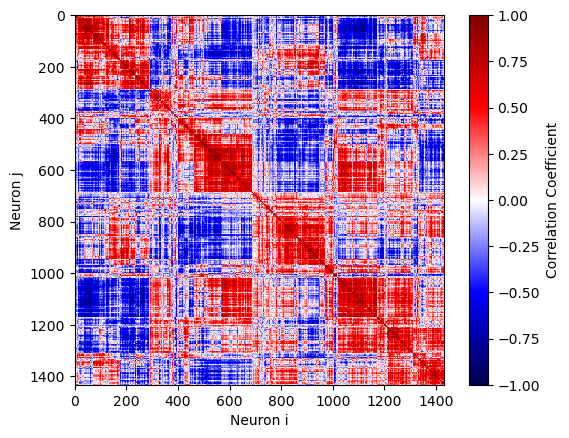

In [37]:
fig, ax = plt.subplots()
h = ax.imshow(Corr[order][:,order], cmap="seismic", vmin=-1, vmax=+1, interpolation="none")
fig.colorbar(h, ax=ax, label="Correlation Coefficient")
ax.set_xlabel("Neuron i")
ax.set_ylabel("Neuron j")

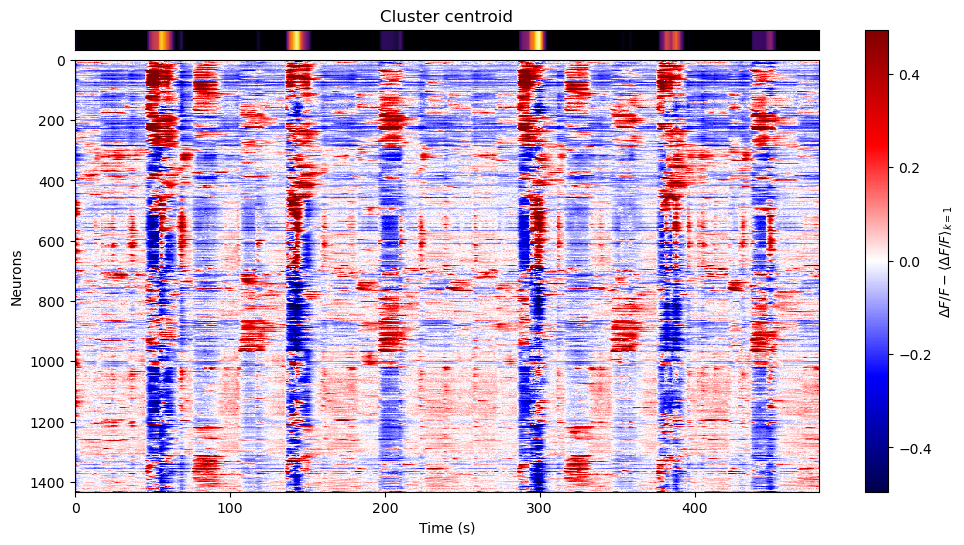

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
l = np.abs(np.quantile(clust_var, [0.01, 0.99])).max()
cr = ComplexRaster(
    ax, clust_var[order],
    signal=small_mu,
    times=brain_time,
    X_params={'cmap': 'seismic', 'vmin': -l, 'vmax': +l},
    signal_params={'cmap': 'inferno', 'vmin': 0, 'vmax': 0.7},
)
cr._ax_sig.set_title("Cluster centroid")
fig.colorbar(cr._im_dff, ax=ax,label=r"$\Delta F/F - \langle \Delta F/F \rangle_{k="+str(k)+"}$")

Do you see the difference ? Can you see some interesting groups of neurons in the raster plot ?

Now let's use the Hierarchical Clustering to identify interesting subclusters within our k-means cluster.  
For the sake of time, we will not try to find the optimal number of clusters $d$ in our hierarchy. However in real life this is definitively something you would like to do, and there are many methods to do so.

Here we will choose to have 7 clusters, and find the cluster labels associated to each neuron.

❗ remember that curently we are not working with our 30k neurons, but only on the neurons in one of the k-means clusters.

In [39]:
N_cut = 7
h_labels = hier.cut_tree(Z, n_clusters=N_cut)[:,0]
h_labels.shape

(1433,)

➡️👤⌨️ **Compute the mean ΔF/F of each hierarchical cluster.** ➡️👤⌨️

💡 you can use the function `extract_cluster_dffs` you made earlier.

In [40]:
# ➡️👤⌨️
mean_clust_act = np.empty((N_cut, small_dffs.shape[1]))
for h in range(N_cut):
    mean_clust_act[h] = extract_cluster_dffs(small_dffs, h_labels, h).mean(axis=0)

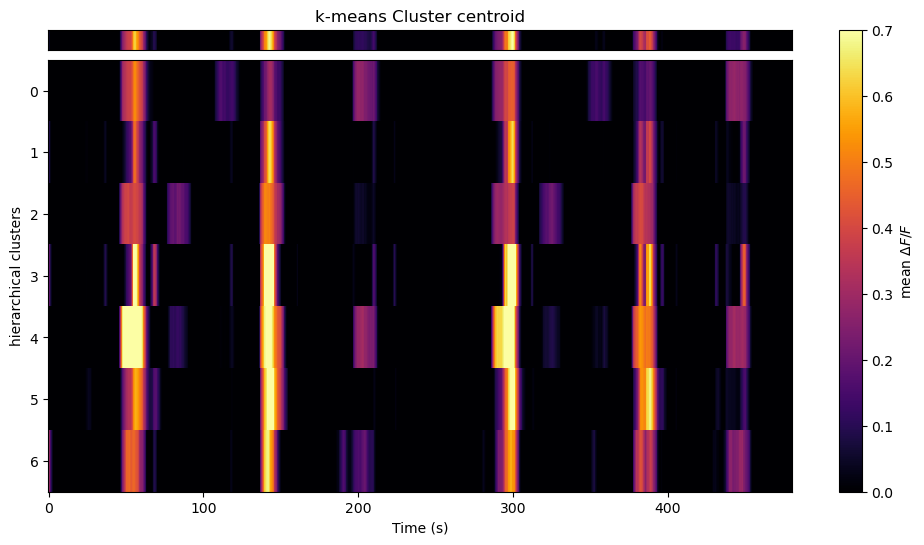

In [41]:
fig, ax = plt.subplots(figsize=(12,6))
cr = ComplexRaster(
    ax, mean_clust_act,
    signal=small_mu,
    times=brain_time,
    X_params={'cmap': 'inferno', 'vmin': 0, 'vmax': 0.7},
    signal_params={'cmap': 'inferno', 'vmin': 0, 'vmax': 0.7},
)
cr.ax.set_ylabel("hierarchical clusters")
cr._ax_sig.set_title("k-means Cluster centroid")
fig.colorbar(cr._im_dff, ax=ax,label=r"mean $\Delta F/F$")

What do you think the difference is between those clusters ?  

To figure that out, let's look at the tuning curves for each of those clusters. 
For a signal $s(t)$ evolving in the context of an experimental parameter $\theta(t)$, the tuning curve is the function $s(\theta)$ which tells you how this signal $s$ is *associated* with the parameter $\theta$. In our case, $\theta$ is the direction of the stimulus, and $s$ is the mean activity of the cluster.

On the interactive plot bellow, look at the mean activity of the hierarchical clusters and their tuning curves.  
What is the difference between those clusters ?

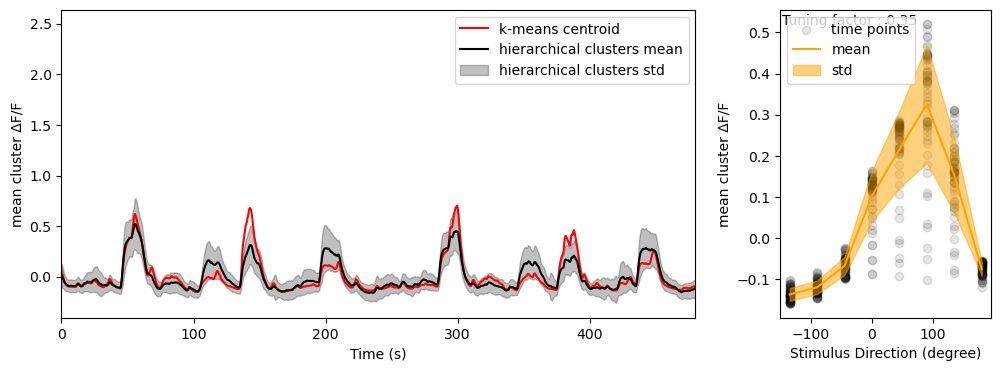

In [43]:
def plot_hier_indv_clust(hk=0):
    inds = np.where(h_labels==hk)[0]
    fig = plt.figure(figsize=(12,4))
    gs = fig.add_gridspec(ncols=2, width_ratios=[0.75, 0.25])
    ax = fig.add_subplot(gs[0])
    mean = small_dffs[inds].mean(axis=0)
    std = small_dffs[inds].std(axis=0)
    ax.plot(brain_time, small_mu, label="k-means centroid", color="red")
    ax.plot(brain_time, mean, color="k", label="hierarchical clusters mean")
    ax.fill_between(brain_time, mean+std, mean-std, color="k", alpha=0.25, label="hierarchical clusters std")
    ax.set_xlim(brain_time[0], brain_time[-1])
    ax.set_ylim(small_dffs.min(), small_dffs.max())
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("mean cluster ΔF/F")
    ax.legend()
    ax = fig.add_subplot(gs[1])
    plot_tuning_curve(ax, direction, small_dffs[inds].mean(axis=0))
    ax.set_xlabel("Stimulus Direction (degree)")
    ax.set_ylabel("mean cluster ΔF/F")
    ax.legend()
    plt.show()
widgets.interact(plot_hier_indv_clust, hk=(0,N_cut-1, 1))

# 2. PCA

In this section, we will use Principle Componant Analysis (PCA) the reduce the dimentionality of of our neuron-activity data.  

**A quick reminder about PCA :**

PCA is a dimentionality reduction technique which tries to loose as little information as possible. How does it do this ?  
Imagine your data exists in $D$ dimentions, each of your observations will be a point $\mathbf{x} = (x_1, ..., x_D)$ in this $D$dimentions space. PCA creates a linear transformation $T$, from $\mathbf{x}$ to $\mathbf{y} = (y_1, ..., y_d)$ : $$\mathbf{y} = \mathbf{x} \mathbf{T}$$
with $d<D$ (the output space is smaller than the input space).  
The linear transformation $T$ can be seen as a coordinate change (see diagram).  
In simplified terms, PCA will try to find the directions in $D$space, along which your data has the most information.

## 2.1 Building your intuition of PCA

Let's try to build an intuition for what PCA does by first looking at a couple of neurons.  
➡️👤⌨️ **Select 1000 neurons at random, and compute the correlation matrix between them.** ➡️👤⌨️

In [44]:
n = 1000
rand_inds = np.arange(dffs.shape[0])
np.random.shuffle(rand_inds)
rand_inds = rand_inds[:n]
C = np.corrcoef(dffs[rand_inds])
assert C.shape==(n,n), "Your correlation matrix is not the right shape."

Text(0.5, 1.0, 'Correlation between pairs of neurons \n (1000 random neurons)')

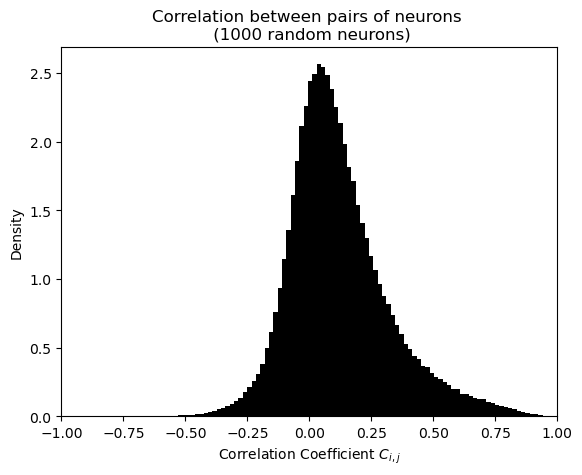

In [45]:
fig, ax = plt.subplots()
ax.hist(C[np.triu_indices_from(C, k=+1)], bins=100, color="k", density=True);
ax.set_xlim(-1,+1)
ax.set_xlabel("Correlation Coefficient $C_{i,j}$")
ax.set_ylabel("Density")
ax.set_title(f"Correlation between pairs of neurons \n ({n} random neurons)")

As you can see, most of the pairwise correlation coefficients $C_{ij}$ are around $0$, meaning that a lot of neurons are not correlated with each other. **However**, there is still a lot of *strong* positive and negative correlations, which means that some neurons have very similar activities, and others have very *opposite* activities.

As a very easy first example, let's look at just 3 neurons.  
➡️👤⌨️ **Compute the paiwise correlations matrix between those 3 neurons.** ➡️👤⌨️ Can you guess why we choose those 3 neurons ?

In [46]:
i,j,k = 15108, 16194, 15735

In [47]:
# ➡️👤⌨️
dff3 = np.stack([dffs[i], dffs[j], dffs[k]])
C3 = np.corrcoef(dff3)
C3

array([[ 1.        , -0.73029878,  0.93750617],
       [-0.73029878,  1.        , -0.70449431],
       [ 0.93750617, -0.70449431,  1.        ]])

Let's look at the activity of those 3 neurons as a 3D parametric plot : $$\vec{X}(t) = \begin{pmatrix} x(t) \\ y(t) \\ z(t) \end{pmatrix} = \begin{pmatrix} \text{dff}_i(t) \\ \text{dff}_j(t) \\ \text{dff}_k(t) \end{pmatrix}$$

Text(0.5, 0, 'neuron k')

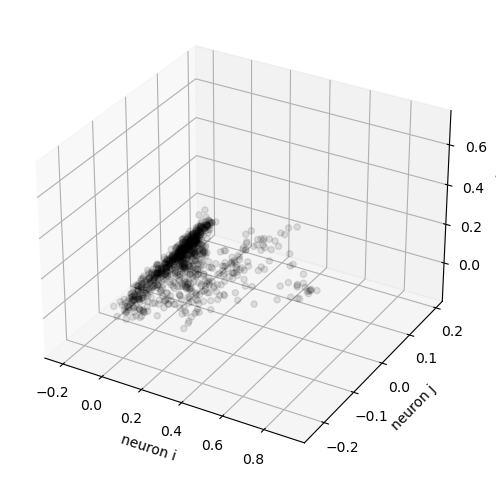

In [48]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection='3d', aspect="auto")
ax.scatter(dff3[0], dff3[1], dff3[2], alpha=0.1, color="k")
ax.set_xlabel("neuron i") ; ax.set_ylabel("neuron j") ; ax.set_zlabel("neuron k")

What can you say about the way $\vec{X}$ is distributed in this 3D space ?  
Instead of the orthogonal basis $(\vec{x},\vec{y},\vec{z})$ axes, can you find other set of axes would describe this data in a simpler way ?

Well this is exactly what PCA does !

In [49]:
pca = PCA(n_components=3)
pca.fit(dff3.T)

PCA(n_components=3)

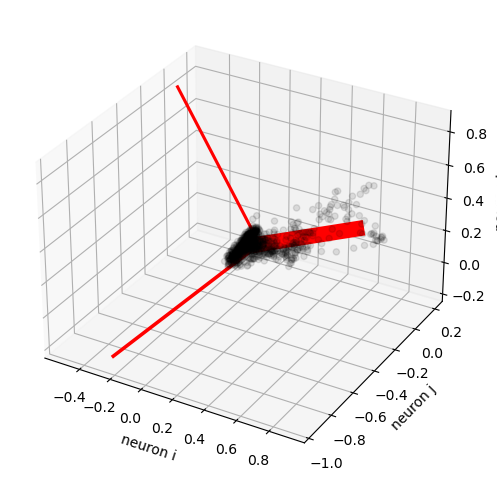

In [50]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection='3d', aspect="auto")
ax.scatter(dff3[0], dff3[1], dff3[2], alpha=0.1, color="k")
ax.set_xlabel("neuron i") ; ax.set_ylabel("neuron j") ; ax.set_zlabel("neuron k")

for c in range(pca.n_components):
    a = pca.mean_
    b = pca.mean_+pca.components_[c]#*pca.explained_variance_ratio_[c]
    ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], color="red", linewidth=(pca.explained_variance_ratio_[c]*10)+2)

In [51]:
pca.explained_variance_ratio_

array([0.92148333, 0.0567592 , 0.02175747])

In [52]:
pca.explained_variance_ratio_.sum()

0.9999999999999999

## 2.2 Breaking your intuition of PCA

Now that you have a better idea of how PCA works, let's illustrate why the results of PCA are often very hard to interpret.  

In this section we will create fake neuronal data which has some perticular temporal structure, apply PCA on this data, and try to interpret the results.

To create our fake neuronal data we will use the following 2 functions : 
- `fake_bump` which creates the ΔF/F of a spike train for a single neuron.
- `fake_chirp` which creates a ΔF/F matrix of `N` neurons which fire onces, one after the other.

![Fake data](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/FakeChirp.png)

Text(0, 0.5, 'Fake ΔF/F')

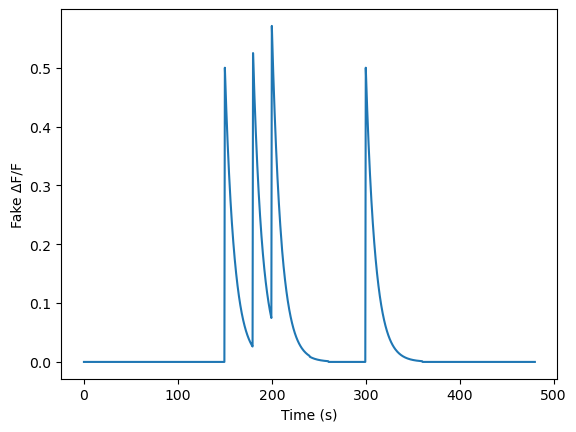

In [8]:
fig, ax = plt.subplots()
ax.plot(brain_time, fake_bump(brain_time, [150,180,200,300], tau=10))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Fake ΔF/F")

➡️👤⌨️ **Use `fake_chirp` to create fake ΔF/F for 300 neurons with a characteristic calcium time constant $\tau=30s$** ➡️👤⌨️  
(you can use `brain_time` as the `ts`)

In [9]:
# ➡️👤⌨️ 
fake_dff = fake_chirp(brain_time, N=300, tau=30)

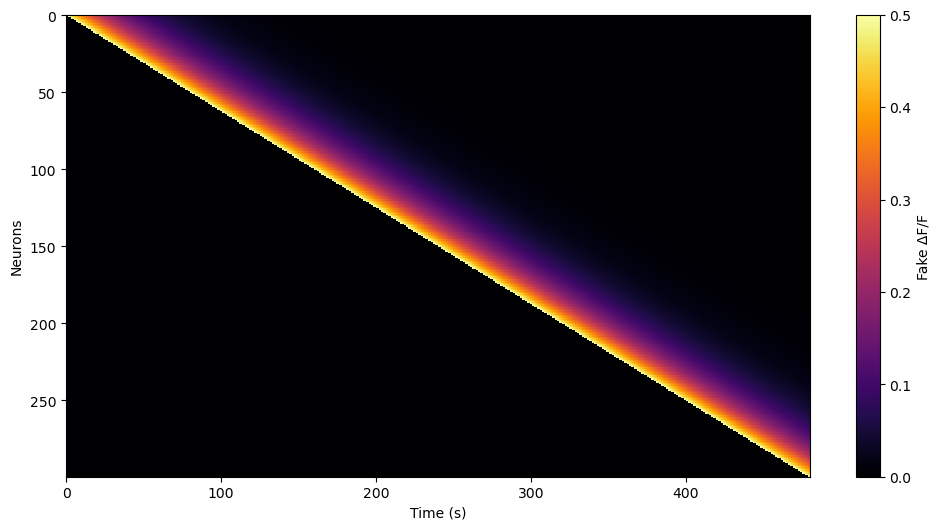

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
cr = ComplexRaster(ax, fake_dff,times=brain_time,X_params={'cmap': 'inferno', 'vmin': 0, 'vmax': 0.5},)
fig.colorbar(cr._im_dff, ax=ax,label="Fake ΔF/F")

Now let's perform a PCA on this fake data, and project it onto the PCA componants.

Projecting onto the PCA componants means that we will take our ΔF/F (which is in $D$ dimentions) and map it onto the PCA components (which are in $d$ dimentions). This is why PCA is a dimentionality reduction method $D→d$. Mathematicaly this is done like so : $$\mathbf{y} = \mathbf{x} \mathbf{T}$$, with $\mathbf{x}$ the ΔF/F matrix, $\mathbf{T}$ the PCA transformation, and $\mathbf{y}$ the projection.

In [11]:
pca = PCA(n_components=100)
pca.fit(fake_dff.T)
Y = pca.transform(fake_dff.T)

➡️👤⌨️ *Using `np.cumsum`, compute the cumulative explained variance curve.* ➡️👤⌨️

💡 the cumulative explained variance curve  : $$\text{cvar}(p) = \sum_{i=0}^{p-1}\text{var}(i)$$ where $\text{var}(i)$ is the explained variance ratio of the PCA componant $i$

In [12]:
# ➡️👤⌨️
cumul_explained_var = np.cumsum(pca.explained_variance_ratio_)

Text(0, 0.5, '$cvar(p)$ (%)')

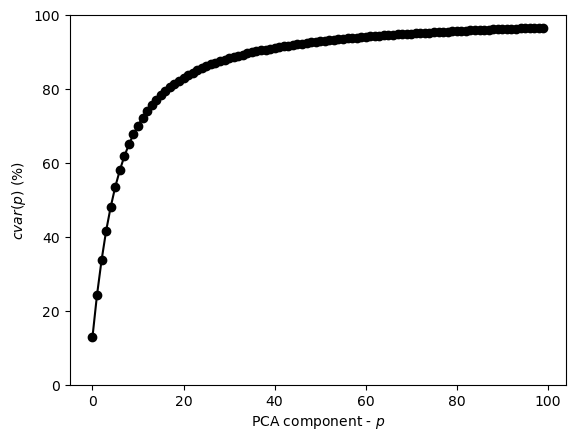

In [13]:
fig, ax = plt.subplots()
ax.plot(cumul_explained_var*100, "-o",color="k")
ax.set_ylim(0,100)
ax.set_xlabel("PCA component - $p$")
ax.set_ylabel(r"$cvar(p)$ (%)")

As you can see, the first $\approx 20$ componants explain most of the variance. And with 100 componants, our PCA explain in total around $95\%$ of the variance.

Before going any further, make a prediction in your head : **What do you expect the first few components of PCA to look like ?**  
Let's see if you were right 🤔

Text(0, 0.5, 'Projected Fake ΔF/F')

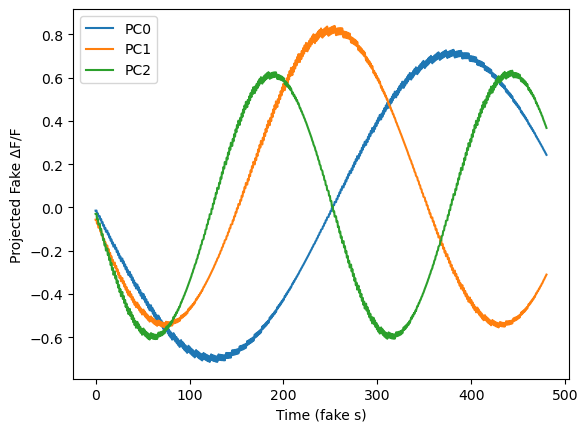

In [14]:
fig, ax = plt.subplots()
for p in range(3):
    ax.plot(brain_time, Y[:,p], label=f"PC{p}")
ax.legend()
ax.set_xlabel("Time (fake s)")
ax.set_ylabel("Projected Fake ΔF/F")

Text(0.5, 0, 'PC2')

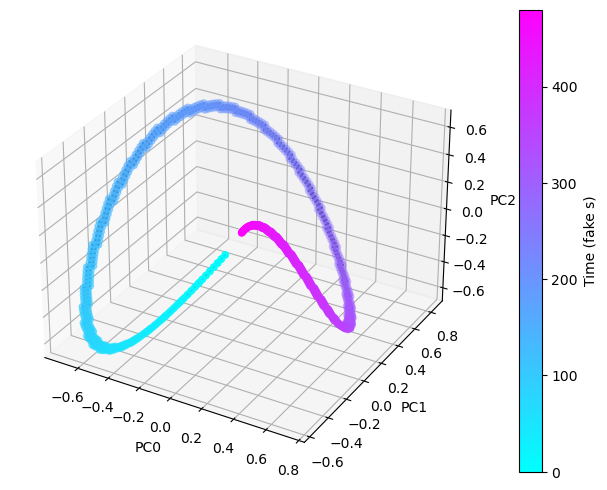

In [15]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection='3d', aspect="auto")
ax.plot(Y[:,0], Y[:,1], Y[:,2], color="k")
h = ax.scatter(Y[:,0], Y[:,1], Y[:,2], c=brain_time, cmap="cool")
fig.colorbar(h, ax=ax, label="Time (fake s)")
ax.set_xlabel("PC0") ; ax.set_ylabel("PC1") ; ax.set_zlabel("PC2")

Did you expect that ?? How would you interpret these PCA componants ?

To try and better understand what is going on here, lets look at the coefficients of the PCA transformation matrix $T_{pn}$ (with $p$ being each componant and $n$ each neuron).

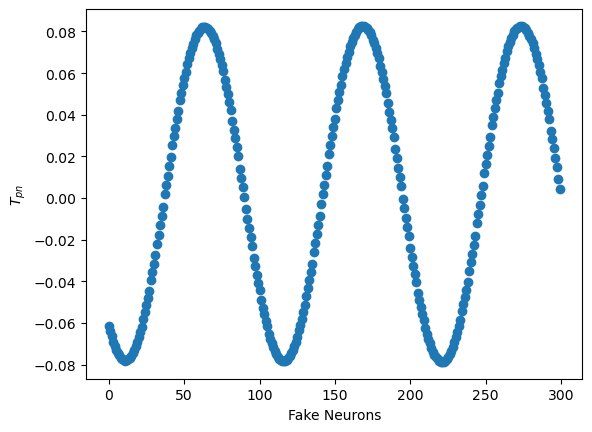

In [17]:
def plot_fake_pca_coeffs(p=0):
    fig, ax = plt.subplots()
    x = np.arange(fake_dff.shape[0])
    ax.scatter(x, pca.components_[p])
    ax.set_xlabel("Fake Neurons")
    ax.set_ylabel(r"$T_{pn}$")
    plt.show()
widgets.interact(plot_fake_pca_coeffs, p=(0,10, 1))

As you can see, the components have hight and low coefficients for multiple neurons, which are not necessarily next to each other (meaning that they don't fire during the same time intervals).  

This illustrates a very important aspect of PCA : **PCA is not Clustering !!!**  
A component of PCA does not represent a group of neurons with a perticular activity. PCA components represent modes of activity of the data, which can be much harder to interpret. (in the perticular case of `fake_chirp` these modes are Fourier modes, similar to what you can see on [this video](https://youtu.be/PVX4V5Adbzk?t=23))  

If you are interested in learning more about this, you can do the rest of this section which will involve creating random fake data and re-running the same analysis as we did above. However **this is optional, you can move directly to section 2.3 if you want**.

➡️👤⌨️ **Complete the following function to create random ΔF/F matrix. Then generate fake data for 300 neurons, with a characteristic calcium time constant $\tau=30s$, and on average 5 spikes per neurons. Then re-run the last few cells (starting  with the last raster plot) to see what the PCA on this data looks like.** ➡️👤⌨️

What can you conclude ?

In [18]:
def fake_poisson(ts, N=30, tau=10, lamb=5):
    """Create ΔF/F matrix of random neuron activation.

    We want the probability that each neuron spikes at a 
    given time point to follow a poisson distribution.
    
    Parameters :
    ------------
    :ts: 1D array
        times at which we "observe" the neurons.
    :N: int
        number of neurons
    :tau: float
        characteristic time of the calcium decay.
    :lam: float
        average number of spikes per neuron.

    Return :
    :Y: 2D array, (N, len(:ts:))
        ΔF/F associated with the spike trains.
    """
    Y = np.empty((N,len(ts)))
    for i in range(N):
        # ➡️👤⌨️
        n = np.random.poisson(lam=lamb)
        Y[i] = fake_bump(ts, np.random.uniform(ts[0], ts[-1], size=n), tau=tau)
        # ➡️👤⌨️
    return Y

In [19]:
# ➡️👤⌨️
fake_dff = fake_poisson(brain_time, N=300, tau=30, lamb=4)

## 2.3 Finding how many components to keep

Every time we perform a dimentionality reduction $D → d$, we have have to ask ourselves *what is $d$ ?* This question can be quite tricky to answer.

In the case of PCA, $d$ is the number of components. In this section, we will see an easy method to determine how many components to keep during a PCA. This method is called a [Scree plot](https://en.wikipedia.org/wiki/Scree_plot) or [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). (❗ this method is not perfect and should be used with care, we encourage you to read on the subject before using it in publication)

➡️👤⌨️ First, lets **make a PCA with a large number of components `n_components=100`, fit it with `dffs`, and project.** ➡️👤⌨️ 

In [20]:
# ➡️👤⌨️
pca = PCA(n_components=100)
pca.fit(dffs.T)
Y = pca.transform(dffs.T)

➡️👤⌨️ Now, **compute $\text{cvar}(p)$.** ➡️👤⌨️

In [21]:
# ➡️👤⌨️ 
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

(0.0, 100.0)

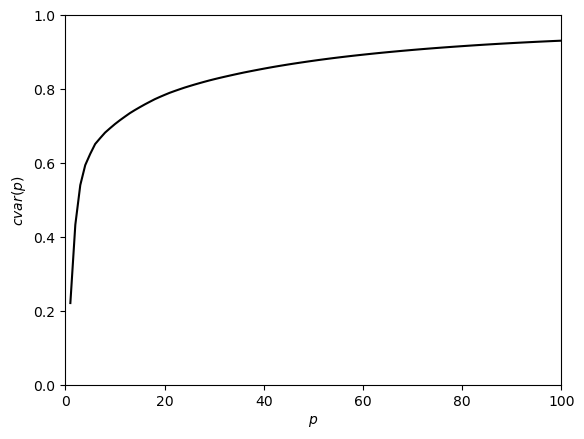

In [22]:
fig, ax = plt.subplots()
x = np.arange(1,pca.n_components+1)
ax.plot(x, cum_exp_var, color="k")
ax.set_ylabel(r"$cvar(p)$")
ax.set_xlabel(r"$p$")
ax.set_ylim(0,1)
ax.set_xlim(0,x.max())

Now let's find the *elbow* in the curve, that is, the point at which the curve has maximum curvature. We will do this using the `KneeLocator` function from the `kneed` librairy.

the previous plot was updated


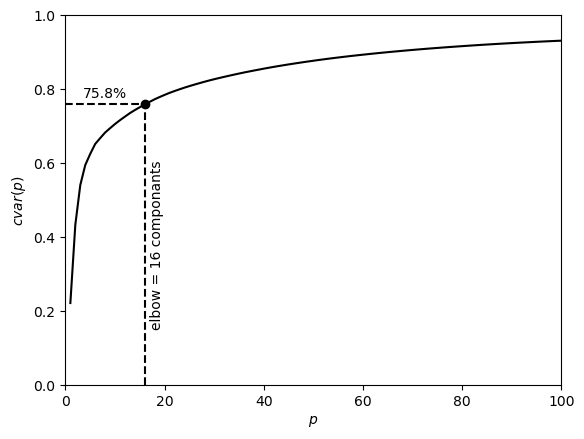

In [24]:
kl = KneeLocator(x, cum_exp_var, curve="concave", direction="increasing")

ax.scatter(kl.elbow, cum_exp_var[kl.elbow-1], color="k")
ax.vlines(kl.elbow, 0, cum_exp_var[kl.elbow-1], color="k", linestyle="--")
ax.hlines(cum_exp_var[kl.elbow-1], 0, kl.elbow, color="k", linestyle="--")
ax.text(kl.elbow+1, cum_exp_var[kl.elbow-1]/2, f"elbow = {kl.elbow} componants", ha="left", va="center", rotation="vertical")
ax.text(kl.elbow/2, cum_exp_var[kl.elbow-1]+0.01, f"{cum_exp_var[kl.elbow-1]*100:0.1f}%", ha="center", va="bottom")
print("the previous plot was updated")

From this quick analysis, it seams that **16 components of PCA** is enough. It will discribe ~76% of the data variance which is quite good.

## 2.4 Apply to the data

Now that we know how many components to keep, let's create a PCA projection and investigate what it tells us aout our data.

First lets fit the transformation:

In [25]:
pca = PCA(n_components=16)
pca.fit(dffs.T)
Y = pca.transform(dffs.T)

➡️👤⌨️ **Get the percentage of explained variance for each component and the total explained variance.**  ➡️👤⌨️ 

In [26]:
# ➡️👤⌨️ 
exp_var = pca.explained_variance_ratio_
exp_var_tot = exp_var.sum()

Total explained variance = 75.8%


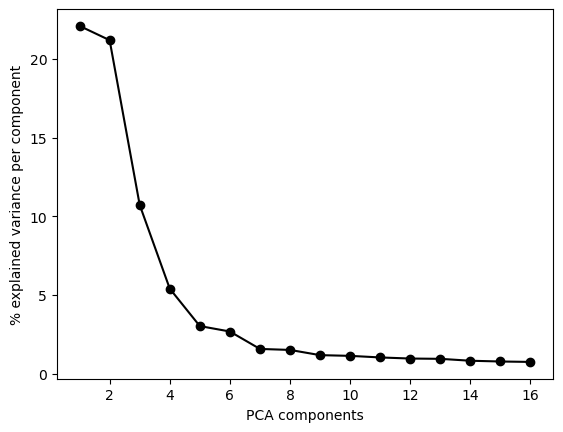

In [27]:
print(f"Total explained variance = {exp_var_tot*100:0.1f}%")
fig, ax = plt.subplots()
ax.plot(np.arange(1, pca.n_components+1), exp_var*100, "-o", color="k")
ax.set_xlabel("PCA components")
ax.set_ylabel("% explained variance per component");

You can see that the first ~4 components explain most of the variance.

Let's now look at the projected ΔF/F `Y`.

Text(0, 0.5, 'PCA Componants')

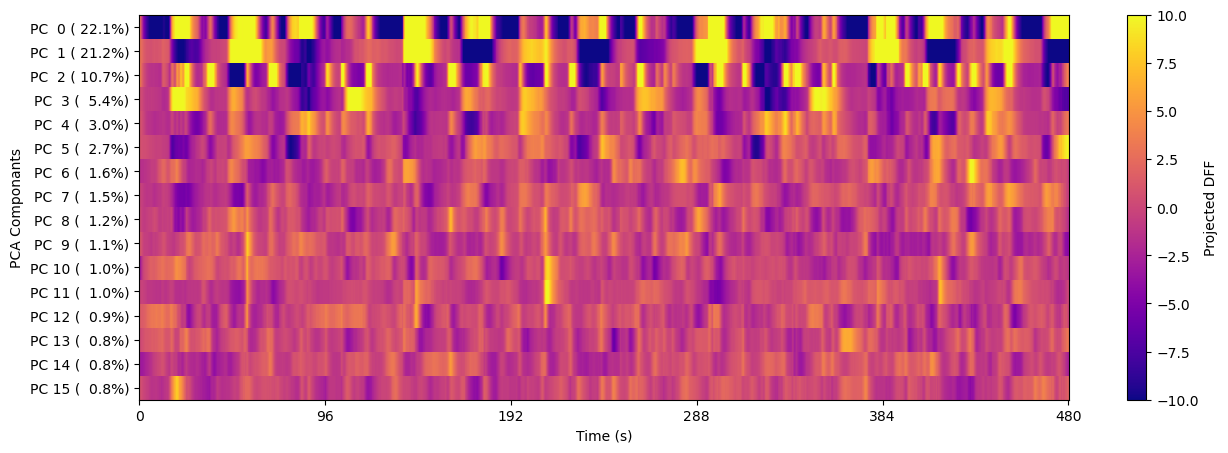

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
h = ax.imshow(Y.T, aspect="auto", cmap="plasma", interpolation="none", vmin=-10, vmax=+10)
fig.colorbar(h, ax=ax, label="Projected DFF")
ax.set_yticks(
    np.arange(pca.n_components), 
    labels=[f"PC{i:3} ({pca.explained_variance_ratio_[i]*100:5.1f}%)" for i in range(pca.n_components)],
);
x = np.linspace(0,len(brain_time)-1, 6, dtype=int)
ax.set_xticks(x, labels=brain_time[x].astype(int))
ax.set_xlabel("Time (s)")
ax.set_ylabel("PCA Componants")

IntSlider(value=0, description='Component :', max=15)

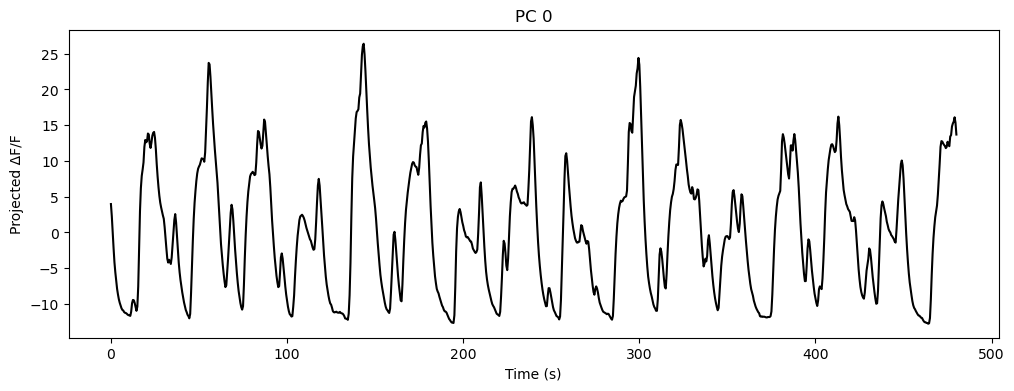

In [29]:
fig, ax_libo = plt.subplots(figsize=(12,4))
line, = ax_libo.plot(brain_time, Y[:,0], color="k")
ax_libo.set_xlabel("Time (s)")
ax_libo.set_ylabel("Projected ΔF/F")
ax_libo.set_title("PC 0")

def update(change):
    i = change.new
    y = Y[:,i]
    line.set_ydata(y)
    ax_libo.set_ylim(y.min(), y.max())
    ax_libo.set_title(f"PC {i}")
    fig.canvas.draw()
slid = widgets.IntSlider(value=0, min=0, max=pca.n_components-1, step=1, description="Component :")
slid.observe(update, names="value")
slid

What can you say about this projected activity ?  
Does it look structured ?  
Which components seem to hold most of the information ? Which components seem to be most interpretable ?

As we said before, one of the key features of PCA is that all components are *orthogonal* to each other. This means that they are independent of each other.

➡️👤⌨️ **Show that the components are not correlated with each other.** ➡️👤⌨️

💡 you can use the function `np.corrcoef`.

In [30]:
# ➡️👤⌨️
C_comp = np.corrcoef(Y.T)

Text(0, 0.5, 'Density')

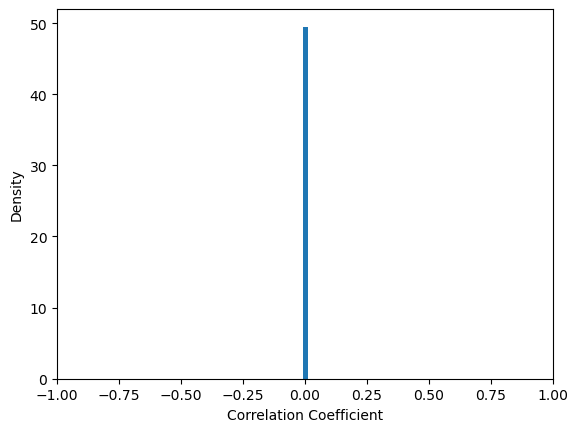

In [31]:
fig, ax = plt.subplots()
ax.hist(C_comp[np.triu_indices_from(C_comp, k=+1)], bins=np.linspace(-1,+1, 100), density=True);
ax.set_xlim(-1,1)
ax.set_xlabel("Correlation Coefficient")
ax.set_ylabel("Density")

Now let's look in more detail at each PCA component, how the coefficients are distributed in the brain, and the activity of neurons ordered by their coefficients.  
Which components seem the most meaningfull to you ?

IntSlider(value=1, description='Component :', max=15)

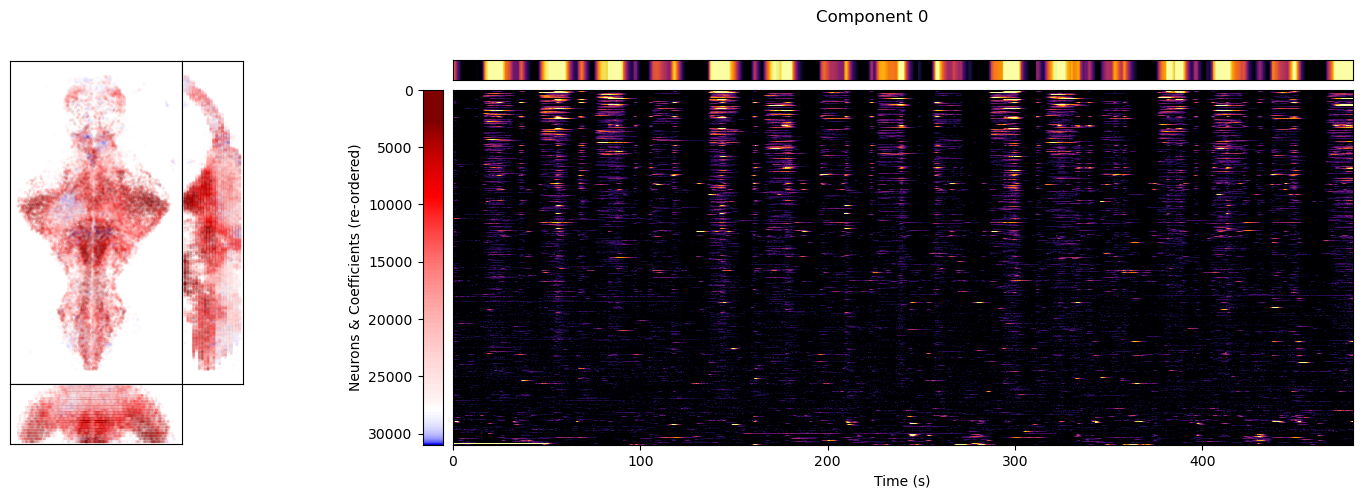

In [35]:
order = np.argsort(pca.components_[0])[::-1]
wr = 0.2
fig = plt.figure(figsize=(15,5))
gs = GridSpec(nrows=1,ncols=2, figure=fig, width_ratios=[wr, 1-wr])

subfig1 = fig.add_subfigure(gs[0,0])
ortho = OrthoAxes(subfig1, coords, interactive=False)
scat = ortho.scatter(coords, c=pca.components_[0], cmap="seismic", vmin=-0.01, vmax=+0.01, alpha=0.1, s=5)

subfig2 = fig.add_subfigure(gs[0,1])
title = subfig2.suptitle("Component 0")
ax = subfig2.add_subplot(111)
pca_cr = PCA_raster(ax, dffs, pca, times=brain_time, k=0)

def update(change):
    k = change.new
    ortho.change_color(scat, pca.components_[k])
    pca_cr.change_component(k)
    title.set_text(f"Component {k}")
    fig.canvas.draw()

slid = widgets.IntSlider(value=0, min=0, max=pca.n_components-1, step=1, description="Component :")
slid.observe(update, names="value")
slid

## 2.5 Interpretability of the PCA components

When looking at the projected ΔF/F activity on the different PCA components, were you able to interpret the signal ?  
Have you identified perticular components which seem to be related to tail motion or to the stimulus ?

In this section we will try to get a better understanding of what the different components *represent*. We will **first focus on the visual stimulus.**

➡️👤⌨️ Let's start by **computing the correlation coefficient `cor_comp_dir` between the direction of the stimulus `direction` and the projected ΔF/F `Y`.** ➡️👤⌨️

⚠️ `direction` contains NaNs, and `np.corrcoef` cannot deal with NaNs. You will need to use the function `np.isfinite` to find where `direction`$\neq$NaN.  
⚠️ `cor_comp_dir` should be a 1D array.

In [36]:
# ➡️👤⌨️
finite = np.isfinite(direction)
C = np.corrcoef(direction[finite], Y[finite].T)
cor_comp_dir = C[0,1:]

In [37]:
cor_comp_dir

array([ 0.11466338,  0.60083119, -0.31830869, -0.36028267,  0.32854067,
       -0.25649884,  0.05263909, -0.23592122, -0.17285269,  0.0894371 ,
       -0.00768494,  0.13382445, -0.08365905, -0.01775599,  0.12906962,
       -0.18756225])

IntSlider(value=0, description='Component :', max=15)

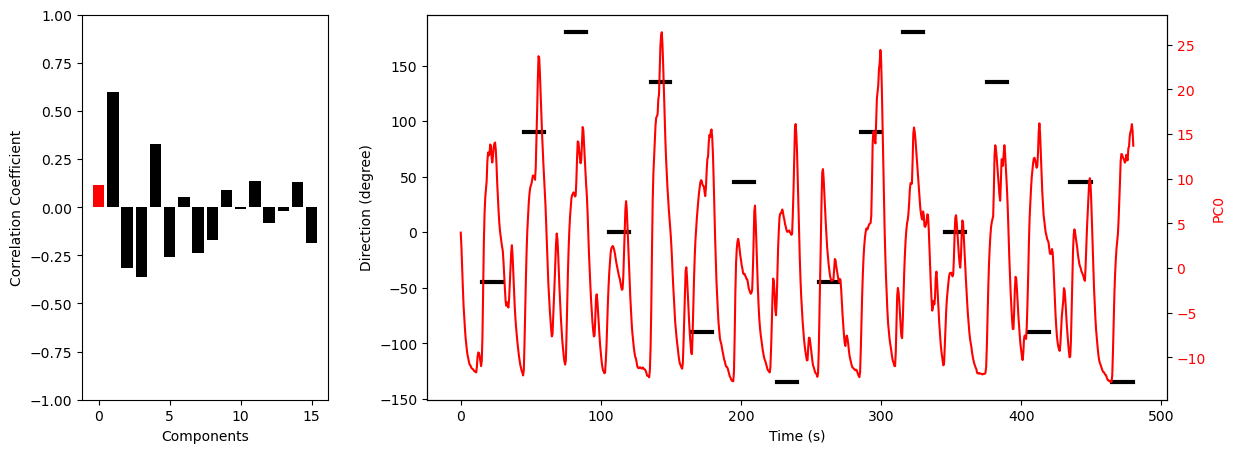

In [38]:
fig = plt.figure(figsize=(2*7, 5))
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[0.25, 0.75])
ax2c = "red"

ax0 = fig.add_subplot(gs[0,0])
colors = ["k" for _ in range(pca.n_components)]
colors[0] = ax2c
ax0.bar(np.arange(pca.n_components), cor_comp_dir, color=colors)
ax0.set_ylim(-1,+1)
ax0.set_xlabel("Components")
ax0.set_ylabel("Correlation Coefficient")

ax1 = fig.add_subplot(gs[0,1])
ax2 = ax1.twinx()
ax1.plot(brain_time, direction, linewidth=3, color="k")
line, = ax2.plot(brain_time, Y[:,0], color=ax2c)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Direction (degree)")
lab = ax2.set_ylabel("PC0", color=ax2c)
ax2.tick_params(axis='y', labelcolor=ax2c)

def update(change):
    k = change.new
    colors = ["k" for _ in range(pca.n_components)]
    colors[k] = ax2c
    ax0.bar(np.arange(pca.n_components), cor_comp_dir, color=colors)
    line.set_ydata(Y[:,k])
    lab.set_text(f"PC{k}")
    ax2.set_ylim(Y[:,k].min(), Y[:,k].max())
    fig.canvas.draw()

slid = widgets.IntSlider(value=0, min=0, max=pca.n_components-1, step=1, description="Component :")
slid.observe(update, names="value")
slid

So according to you, is there one PCA component which decodes the stimulus direction ? Only the stimulus direction ?  
Recompute above the correlation vector, but this time for `flow_on` insteed of direction. Same question ...

Let's look at the tuning curves for the different components.  
According to you, which component(s) is/are clearly tuned towards certain stimulus directions ?

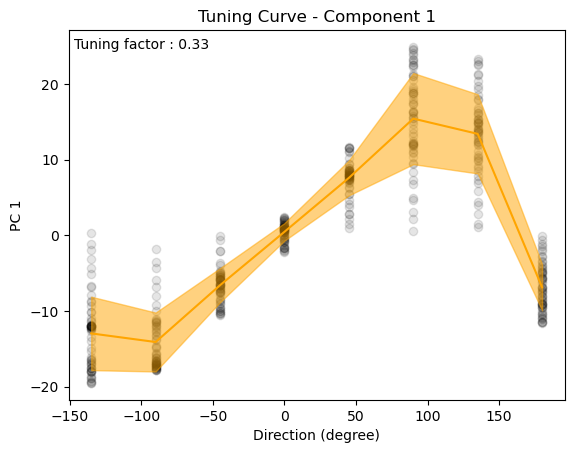

In [40]:
def plot_tuning_curve_ann(k=0):
    fig, ax = plt.subplots()
    plot_tuning_curve(ax, direction, Y[:,k])
    ax.set_title(f"Tuning Curve - Component {k}")
    ax.set_xlabel("Direction (degree)")
    ax.set_ylabel(f"PC {k}")
    plt.show()
widgets.interact(plot_tuning_curve_ann, k=(0,pca.n_components-1,1))

As you saw, there is no unique component clearly dedicated to the stimulus orientation. However, this doesn't neceseraly mean that the information about orientation has been lost during $D→d$. The orientation could still be encoded has a combinaison of multiple components.   
Thus, let's see what happens if we combine multiple components in a 2D space. 

By changing the 2 componants displayed in x and y, **can you find interesting ways to split the 2D space into stimulus-relevant regions ? Does it help at all to better interpret the PCA components ?**

/SEC/ZebraFish/Tools_Analysis/IBIO-Banyuls2023-Python/corrections/../Helper_Functions/plotting_functions.py:556: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels([f"{int(tt)}°" for tt in t], fontdict={'fontweight':"bold"})


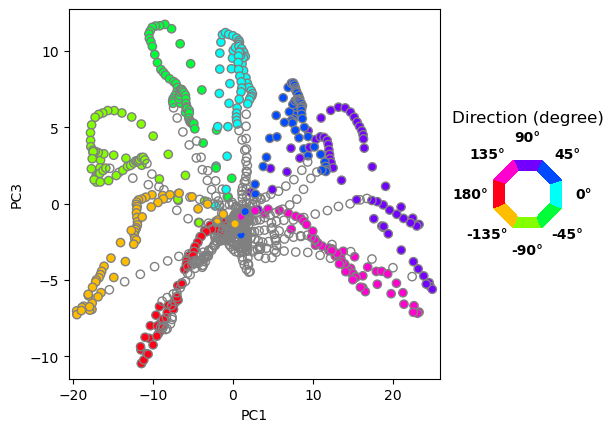

In [44]:
fig, ax = plt.subplots()
h = ax.scatter(Y[:,0], Y[:,1],c=direction, cmap=plt.cm.hsv, vmin=-180, vmax=+180, edgecolor="grey")
plot_angle_colorbar(h, label="Direction (degree)")
labx = ax.set_xlabel("PC0")
laby = ax.set_ylabel("PC1")
k,l = 0,1
data = np.c_[(Y[:,k], Y[:,l])]
h.set_offsets(data)
def updateboth():
    labx.set_text(f"PC{k}")
    laby.set_text(f"PC{l}")
    data = np.c_[(Y[:,k], Y[:,l])]
    h.set_offsets(data)
    ax.set_xlim(Y[:,k].min()-1, Y[:,k].max()+1)
    ax.set_ylim(Y[:,l].min()-1, Y[:,l].max()+1)
    fig.canvas.draw()
def updatex(change):
    global k 
    k = change.new
    updateboth()
def updatey(change):
    global l
    l = change.new
    updateboth()
slidx = widgets.IntSlider(value=0, min=0, max=pca.n_components-1, step=1, description="X Component :")
slidx.observe(updatex, names="value")
slidy = widgets.IntSlider(value=1, min=0, max=pca.n_components-1, step=1, description="Y Component :")
slidy.observe(updatey, names="value")
widgets.VBox([slidx, slidy])

Let's do the same thing, but this time in 3D.

In [45]:
def plot_3d_pca(i=0,j=1,k=2):
    fig3 = plt.figure(figsize=(12,6))
    ax3 = fig3.add_subplot(projection='3d', aspect="auto")
    h3 = ax3.plot(Y[:,i], Y[:,j], Y[:,k], color="k")
    h3 = ax3.scatter(Y[:,i], Y[:,j], Y[:,k], c=direction, cmap=plt.cm.hsv, s=50, vmin=-180, vmax=+180, edgecolor="grey")
    plot_angle_colorbar(h, ax=ax3, label="Direction (degree)")
    lab3x = ax3.set_xlabel(f"PC {i}")
    lab3y = ax3.set_ylabel(f"PC {j}")
    lab3z = ax3.set_zlabel(f"PC {k}")
    plt.show()

nnn = pca.n_components-1
widgets.interact(plot_3d_pca, i=(0,nnn,1), j=(0,nnn,1), k=(0,nnn,1))

interactive(children=(IntSlider(value=0, description='i', max=15), IntSlider(value=1, description='j', max=15)…

<function __main__.plot_3d_pca(i=0, j=1, k=2)>

Were you able to find a pair (or triplet) of components for which you can split 2D (or 3d) space according to stimulus direction ?  
**If so, can you explain it using the tuning curves we drew above ?**

Let's look at components 1 and 3, and see if we can use PCA to define groups of neurons with interesting activity.  
We will do that by looking at the coefficients $T_{pn}$, to find for example the neurons which have $T_{1n} > \alpha_1$ and $T_{3n} > \alpha_3$, with $\alpha_1, \alpha_3$ two thresholds.

In [46]:
I,J = 1,3

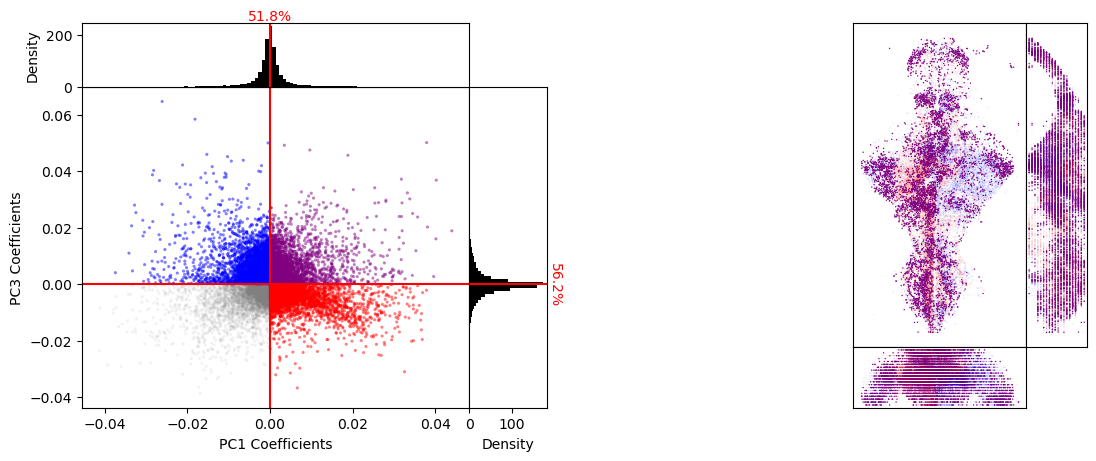

In [47]:
wr = 0.5
cmap_quad = ListedColormap(["grey","r","b", "purple"])
cmap_kwargs = {"vmin":0, "vmax":3, "cmap":cmap_quad}
figj = plt.figure(figsize=(12,5))
gs = GridSpec(
    nrows=1,ncols=2, figure=figj, 
    width_ratios=[wr, 1-wr]
)
subfigj1 = figj.add_subfigure(gs[0,0])
ax_joint = subfigj1.add_subplot(111)
jp = JointPlot(ax_joint, pca.components_[I], pca.components_[J], **cmap_kwargs)
ax_joint.set_xlabel(f"PC{I} Coefficients")
ax_joint.set_ylabel(f"PC{J} Coefficients")

subfigj2 = figj.add_subfigure(gs[0,1])
orthoj = OrthoAxes(subfigj2, coords, interactive=False)
scat = orthoj.scatter(coords, s=1, alpha=0.1*np.ones(coords.shape[1]), c=np.zeros(coords.shape[1], dtype=np.int_), **cmap_kwargs)

joint_widgets = widgets.VBox([
    widgets.HBox([
        widgets.Label(value=f'PC{I}   '),
        widgets.RadioButtons(options=['top', 'bottom'], layout={'width': 'max-content'}), 
        widgets.FloatSlider(value=0,min=pca.components_[I].min(),max=pca.components_[I].max(),step=0.001,continuous_update=False,readout_format='.3f'),
    ]),
    widgets.HBox([
        widgets.Label(value=f'PC{J}   '),
        widgets.RadioButtons(options=['top', 'bottom'], layout={'width': 'max-content'}), 
        widgets.FloatSlider(value=0,min=pca.components_[I].min(),max=pca.components_[I].max(),step=0.001,continuous_update=False,readout_format='.3f'),
    ]),
])
def update_joint(change):
    mask = jp.change_thresh(
        tx=joint_widgets.children[0].children[2].value, 
        ty=joint_widgets.children[1].children[2].value, 
        sidex=joint_widgets.children[0].children[1].value[0], 
        sidey=joint_widgets.children[1].children[1].value[0]
    )
    orthoj.change_color(scat, mask)
    alpha = np.ones_like(mask, dtype=np.float_)*0.1
    alpha[mask<1] = 0.01
    alpha[mask>2] = 1
    orthoj.change_alpha(scat, alpha)
    figj.canvas.draw()
recursive_observe(joint_widgets, update_joint)
update_joint(None)
joint_widgets

You will see that the bigger $|\alpha_1|$ and $|\alpha_3|$, the fewer neurons we select. However, those neurons seem to be spatialy clustered in the brain.  

We could do the same thing with any number of components. On the next (and last) interactive plot, you can select any combinaison of components, and select the % of neurons you want to keep for each component. Explore the different possibilities, have fun, and try to identify groups of neurons which are clustered in space and have interesting temporal activity.

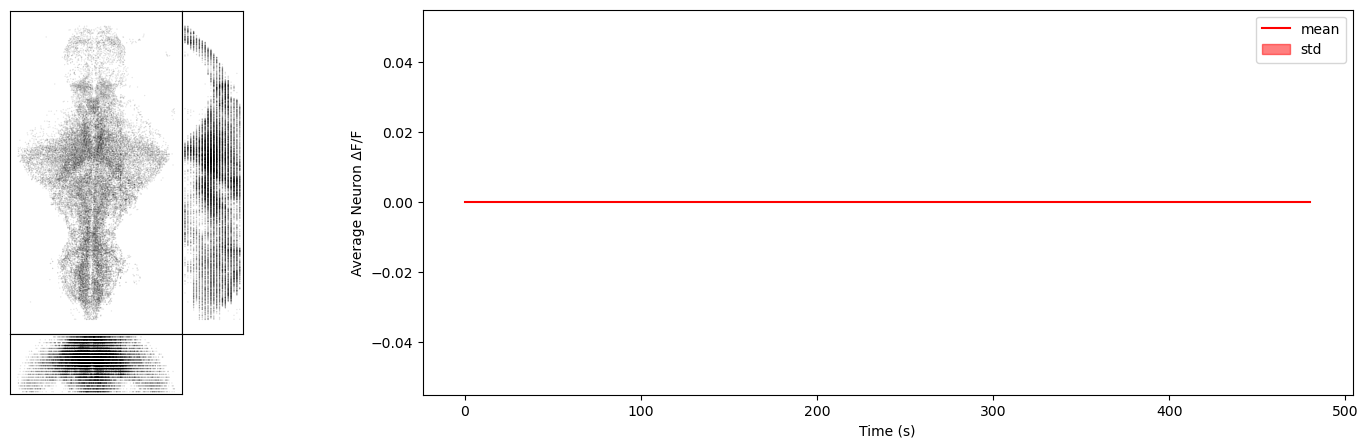

In [48]:
wr = 0.2
figm = plt.figure(figsize=(15,5))
gs = GridSpec(
    nrows=1,ncols=2, figure=figm, 
    width_ratios=[wr, 1-wr]
)
subfigm1 = figm.add_subfigure(gs[0,0])
ortho = OrthoAxes(subfigm1, coords, interactive=False)
scat = ortho.scatter(coords, s=1, alpha=0.1*np.ones(coords.shape[1]), c=np.zeros(coords.shape[1], dtype=np.int_), cmap="flag_r", vmin=0, vmax=1)

subfigm2 = figm.add_subfigure(gs[0,1])
axm2 = subfigm2.add_subplot(111)
zeerooss = np.zeros(dffs.shape[1])
linem, = axm2.plot(brain_time, zeerooss, color="red", label="mean")
fillm = axm2.fill_between(brain_time, zeerooss, zeerooss, color="red", alpha=0.5, label="std")
axm2.legend()
axm2.set_xlabel("Time (s)")
axm2.set_ylabel("Average Neuron ΔF/F")

PC_widgets = widgets_for_pca(5)
def update(change):
    mask = mask_from_widgets(pca, PC_widgets)
    ortho.change_color(scat, mask)
    ortho.change_alpha(scat, np.where(mask, 0.7, 0.1))
    if (~mask).all():
        linem.set_ydata(zeerooss)
        fillm.set_paths([fillm.get_paths()[0].vertices*0])
    else:
        subdff = dffs[mask]
        mean = subdff.mean(axis=0)
        std = subdff.std(axis=0)
        linem.set_ydata(mean)
        dummy = ax.fill_between(brain_time, mean-std,mean+std, alpha=0)
        dp = dummy.get_paths()[0]
        dummy.remove()
        fillm.set_paths([dp.vertices])
        axm2.set_ylim((mean-std).min(), (mean+std).max())
    figm.canvas.draw()
recursive_observe(PC_widgets, update)
update(None)
PC_widgets